In [21]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset, get_dataset_split_names, DatasetDict
from tqdm import tqdm

sns.set_color_codes("colorblind")
sns.set_theme(style="darkgrid")
sns.set_context("talk")
tqdm.pandas()

# set font to times new roman for plots
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

## Load Datasets

In [65]:
split_sample_size = None
label_title_padding = 10
study_pile = False
RECITATION_THRESHOLD = 8

figures_path = f"scale+time_figures/recitation_threshold_{RECITATION_THRESHOLD}/"
if not os.path.exists(figures_path):
    os.makedirs(figures_path)

In [3]:
memories_path = "usvsnsp/generation-semantic-filters"
intermediate_path = "usvsnsp/generation-semantic-intermediate-filters"
memories_dataset = DatasetDict()
pile_dataset = DatasetDict()
splits = [split for split in get_dataset_split_names(memories_path) if "deduped" in split] + get_dataset_split_names(intermediate_path)
splits = [split for split in splits if "deduped" in split]
print(splits)

['pile_deduped_1.4b', 'memories_deduped_410m', 'memories_deduped_1.4b', 'memories_deduped_6.9b', 'memories_deduped_1b', 'pile_deduped_410m', 'pile_deduped_2.8b', 'pile_deduped_160m', 'pile_deduped_6.9b', 'pile_deduped_1b', 'memories_deduped_70m', 'memories_deduped_2.8b', 'pile_deduped_12b', 'memories_deduped_160m', 'pile_deduped_70m', 'memories_deduped_12b', 'memories_deduped_12b.43000', 'memories_deduped_12b.103000', 'memories_deduped_12b.83000', 'memories_deduped_12b.63000', 'memories_deduped_12b.123000', 'memories_deduped_12b.23000']


In [4]:
print("Loading datasets...")
print(f"Split sample size: {split_sample_size}")

for split in tqdm(splits):
    model = split.split("_")[-1]
    checkpoint = int(split.split(".")[-1]) if split.split(".")[-1][1].isnumeric() else 143000
    formatted_split_name = split.replace("memories_", "").replace("deduped_", "deduped.").replace("pile_", "")
    dataset_path = memories_path if checkpoint == 143000 else intermediate_path
    if "memories" in split: 
        # continue # Don't load memories since they're unnecessary for the first part of the analysis
        memories_dataset[formatted_split_name] = load_dataset(dataset_path, split=f"{split}[:{split_sample_size}]" if split_sample_size else split)
    else:
        continue
        pile_dataset[formatted_split_name] = load_dataset(dataset_path, split=f"{split}[:{split_sample_size}]" if split_sample_size else split)

display(memories_dataset)
display(pile_dataset)

Loading datasets...
Split sample size: None


100%|██████████| 22/22 [39:53<00:00, 108.79s/it]  


DatasetDict({
    deduped.410m: Dataset({
        features: ['sequence_id', 'tokens', 'text', 'is_incrementing', 'is_repeating', 'sequence_duplicates', 'max_frequency', 'avg_frequency', 'min_frequency', 'median_frequency', 'p25_frequency', 'p75_frequency', 'frequencies', 'nl_scores', '0_8_snowclones', '0_9_snowclones', '0_8_templates', '0_9_templates', 'huffman_coding_length', 'memorization_score', 'index', 'loss', 'prompt_perplexity', 'generation_perplexity', 'sequence_perplexity'],
        num_rows: 811040
    })
    deduped.1.4b: Dataset({
        features: ['sequence_id', 'tokens', 'text', 'is_incrementing', 'is_repeating', 'sequence_duplicates', 'max_frequency', 'avg_frequency', 'min_frequency', 'median_frequency', 'p25_frequency', 'p75_frequency', 'frequencies', 'nl_scores', '0_8_snowclones', '0_9_snowclones', '0_8_templates', '0_9_templates', 'huffman_coding_length', 'memorization_score', 'index', 'loss', 'prompt_perplexity', 'generation_perplexity', 'sequence_perplexity'],
    

DatasetDict({
    
})

In [5]:
split_to_param_count = {
    "70m": 70000000,
    "160m": 160000000,
    "410m": 410000000,
    "1b": 1000000000,
    "1.4b": 1400000000,
    "2.8b": 2800000000,
    "6.9b": 6900000000,
    "12b": 12000000000,
}

In [6]:
def get_frame_from_split(dataset, split_name, is_pile_sample):
    current_frame = dataset[split].to_pandas()
    current_frame.drop(columns=columns_to_drop, inplace=True)
    checkpoint = int(split.split(".")[-1]) if split.split(".")[-1][1].isnumeric() and len(split.split(".")) != 2 else "Final"
    current_frame["Checkpoint"] = checkpoint
    current_frame["TrainingPercentage"] = 1 if checkpoint == "Final" else checkpoint / 143000
    model = split.split("deduped")[-1][1:] if checkpoint == "Final" else split.split(".")[-2]
    current_frame["Model"] = model
    current_frame["Param Count"] = split_to_param_count[current_frame["Model"].iloc[0]]
    current_frame["Deduped"] = "deduped" in split
    current_frame["Memorized"] = current_frame["memorization_score"] >= 1
    current_frame["IsPileSample"] = is_pile_sample
    return current_frame


columns_to_drop = ["frequencies", "tokens", "text"]
combined_dataframe = None
for split in tqdm(memories_dataset, desc="Loading Memories"):
    current_frame = get_frame_from_split(memories_dataset, split, False)
    if combined_dataframe is None:
        combined_dataframe = current_frame
    else:
        combined_dataframe = pd.concat([combined_dataframe, current_frame])

for split in tqdm(pile_dataset, desc="Loading Pile"):
    current_frame = get_frame_from_split(pile_dataset, split, True)
    combined_dataframe = pd.concat([combined_dataframe, current_frame])

combined_dataframe = combined_dataframe.sort_values("Param Count")
# display(combined_dataframe.shape)
# display(combined_dataframe.columns)
combined_dataframe

Loading Memories: 100%|██████████| 14/14 [00:34<00:00,  2.49s/it]
Loading Pile: 0it [00:00, ?it/s]


,sequence_id,is_incrementing,is_repeating,sequence_duplicates,max_frequency,avg_frequency,min_frequency,median_frequency,p25_frequency,p75_frequency,...,prompt_perplexity,generation_perplexity,sequence_perplexity,Checkpoint,TrainingPercentage,Model,Param Count,Deduped,Memorized,IsPileSample
0,21590,False,False,56,11740996961,9.443266e+08,3053059,277329702.0,20962725,395603541,...,2.551588,1.018116,2.597813,Final,1.000000,70m,70000000,True,True,False
274306,101663513,False,False,4008,11740996961,2.080217e+09,882713,527496690.0,16826629,983717687,...,2.778560,1.010672,2.808212,Final,1.000000,70m,70000000,True,True,False
274305,101568151,False,False,3077,11740996961,1.636690e+09,462611,5492065.0,772190,22658345,...,1.348658,1.016873,1.371414,Final,1.000000,70m,70000000,True,True,False
274304,101528653,False,False,126590,11740996961,2.183443e+09,2535454,397855078.0,24463239,1480613645,...,2.405067,1.001652,2.409041,Final,1.000000,70m,70000000,True,True,False
274303,101488489,False,False,12551,11740996961,2.955296e+09,605886,223388936.0,16400100,4201626736,...,2.173179,1.022547,2.222178,Final,1.000000,70m,70000000,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325534,43193238,False,False,609181,11740996961,2.319468e+09,1612787,24613500.5,5114476,939268059,...,NaN,NaN,NaN,43000,0.300699,12b,12000000000,True,True,False
325533,43187425,False,False,226,11740996961,2.506770e+09,344343,108487617.0,5756465,1480613645,...,NaN,NaN,NaN,43000,0.300699,12b,12000000000,True,True,False
325532,43165692,False,False,3504,11740996961,1.040303e+09,351874,171363758.0,7462193,304221700,...,NaN,NaN,NaN,43000,0.300699,12b,12000000000,True,True,False
325542,43328930,False,False,6731,11740996961,1.400083e+09,711305,90651872.0,11201675,816247750,...,NaN,NaN,NaN,43000,0.300699,12b,12000000000,True,True,False


## Assign Examples to Taxonomy

In [66]:
def get_category(row):
    if row["Memorized"] == False:
        return "Not Memorized"
    if row["sequence_duplicates"] >= RECITATION_THRESHOLD:
        return "Recitation"
    if row["is_incrementing"] or row["is_repeating"]:
        return "Reconstruction"

    return "Recollection"

combined_dataframe["category"] = combined_dataframe.progress_apply(lambda row: get_category(row), axis=1)
combined_dataframe.value_counts(["Model", "Checkpoint", "category"])

100%|██████████| 13510441/13510441 [00:40<00:00, 331829.66it/s]


Model  Checkpoint  category      
12b    Final       Recitation        1540028
6.9b   Final       Recitation        1394394
12b    123000      Recitation        1286666
2.8b   Final       Recitation        1125182
12b    103000      Recitation         983944
1.4b   Final       Recitation         876239
1b     Final       Recitation         867766
12b    83000       Recitation         700108
410m   Final       Recitation         682758
160m   Final       Recitation         492373
12b    63000       Recitation         482596
70m    Final       Recitation         359176
12b    Final       Recollection       304149
       43000       Recitation         297127
6.9b   Final       Recollection       259542
12b    123000      Recollection       254202
2.8b   Final       Recollection       204335
12b    103000      Recollection       192569
1.4b   Final       Recollection       148547
1b     Final       Recollection       141143
12b    83000       Recollection       136926
       23000       Re

## Plot Graphs

### Figure: Count and Memories by Taxonomy Across Time and Scale

In [67]:
combined_memories_dataframe = combined_dataframe[combined_dataframe["IsPileSample"] == False]
combined_memories_dataframe

,sequence_id,is_incrementing,is_repeating,sequence_duplicates,max_frequency,avg_frequency,min_frequency,median_frequency,p25_frequency,p75_frequency,...,generation_perplexity,sequence_perplexity,Checkpoint,TrainingPercentage,Model,Param Count,Deduped,Memorized,IsPileSample,category
0,21590,False,False,56,11740996961,9.443266e+08,3053059,277329702.0,20962725,395603541,...,1.018116,2.597813,Final,1.000000,70m,70000000,True,True,False,Recitation
274306,101663513,False,False,4008,11740996961,2.080217e+09,882713,527496690.0,16826629,983717687,...,1.010672,2.808212,Final,1.000000,70m,70000000,True,True,False,Recitation
274305,101568151,False,False,3077,11740996961,1.636690e+09,462611,5492065.0,772190,22658345,...,1.016873,1.371414,Final,1.000000,70m,70000000,True,True,False,Recitation
274304,101528653,False,False,126590,11740996961,2.183443e+09,2535454,397855078.0,24463239,1480613645,...,1.001652,2.409041,Final,1.000000,70m,70000000,True,True,False,Recitation
274303,101488489,False,False,12551,11740996961,2.955296e+09,605886,223388936.0,16400100,4201626736,...,1.022547,2.222178,Final,1.000000,70m,70000000,True,True,False,Recitation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325534,43193238,False,False,609181,11740996961,2.319468e+09,1612787,24613500.5,5114476,939268059,...,NaN,NaN,43000,0.300699,12b,12000000000,True,True,False,Recitation
325533,43187425,False,False,226,11740996961,2.506770e+09,344343,108487617.0,5756465,1480613645,...,NaN,NaN,43000,0.300699,12b,12000000000,True,True,False,Recitation
325532,43165692,False,False,3504,11740996961,1.040303e+09,351874,171363758.0,7462193,304221700,...,NaN,NaN,43000,0.300699,12b,12000000000,True,True,False,Recitation
325542,43328930,False,False,6731,11740996961,1.400083e+09,711305,90651872.0,11201675,816247750,...,NaN,NaN,43000,0.300699,12b,12000000000,True,True,False,Recitation


In [68]:
# Create plot for data across 
counts_frame_scale = combined_memories_dataframe[combined_memories_dataframe["Checkpoint"] == "Final"].value_counts(["Param Count", "category"]).unstack().reindex(split_to_param_count.values())
counts_frame_scale.to_csv(f"final_checkpoint_counts_recitation={RECITATION_THRESHOLD}.csv")
display(counts_frame_scale)

intermediate_frame = combined_memories_dataframe[combined_memories_dataframe["Model"] == "12b"]
sorted_checkpoints = sorted(sorted(intermediate_frame["TrainingPercentage"].unique(), key=lambda x: int(x)))

counts_frame_time = intermediate_frame.value_counts(["TrainingPercentage", "category"]).unstack().reindex(sorted_checkpoints)
counts_frame_time.to_csv(f"intermediate_checkpoint_counts_recitation={RECITATION_THRESHOLD}.csv")
display(counts_frame_time)

category,Recitation,Recollection,Reconstruction
Param Count,,,
70000000,359176,36918,15354
160000000,492373,68329,20498
410000000,682758,105404,22878
1000000000,867766,141143,23963
1400000000,876239,148547,23318
2800000000,1125182,204335,25699
6900000000,1394394,259542,26360
12000000000,1540028,304149,27039


category,Recitation,Recollection,Reconstruction
TrainingPercentage,,,
0.160839,135964,23613,3841
0.300699,297127,54571,7165
0.440559,482596,91232,11239
0.580420,700108,136926,15034
0.720280,983944,192569,19065
0.860140,1286666,254202,23187
1.000000,1540028,304149,27039


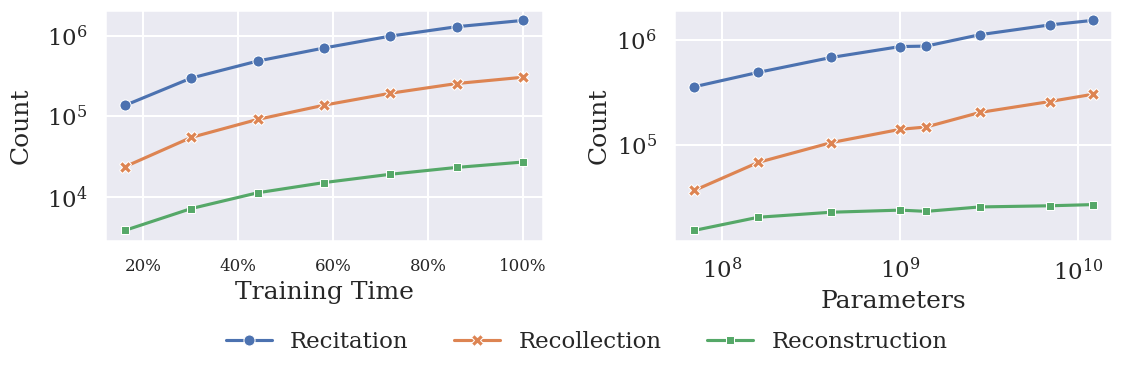

In [69]:
from matplotlib.ticker import PercentFormatter

fig, axes = plt.subplots(1, 2, figsize=(13, 3))

# set figure 1
# first figure is a line plot of the counts of each category for across intermediate checkpoints

sns.lineplot(ax=axes[0], data=counts_frame_time, dashes=False, markers=True, markersize=8)

# rotate x axis labels
# axes[0].tick_params(axis='x', rotation=20)

# Set x axix label to "Training Time"
axes[0].set_xlabel("Training Time")

# make x labels smaller
axes[0].tick_params(axis='x', labelsize=12)

# the x axis values are between 0 and 1. Set the x axis to be a percentage
axes[0].xaxis.set_major_formatter(PercentFormatter(1))

# Add y label for Count
axes[0].set_ylabel("Count", labelpad=label_title_padding)

# add padding for labels
fig.subplots_adjust(wspace=0.2)

# make x and y axis log scale
axes[0].set_yscale("log")

# # have a common legend for both plots centered below the figure. No legend box
axes[0].legend(loc='upper center', bbox_to_anchor=(1.1, -0.3), ncol=4, frameon=False)

# set figure 2
# the second figure is a line plot of the counts of each category across parameter count

sns.lineplot(ax=axes[1], data=counts_frame_scale, dashes=False, markers=True, markersize=8)

# make x and y axis log scale
axes[1].set_xscale("log")
axes[1].set_yscale("log")

# Set x label to "Parameters"
axes[1].set_xlabel("Parameters")

# Add y label for Count
axes[1].set_ylabel("Count")

# remove legend
axes[1].legend().remove()

# add padding for labels
fig.subplots_adjust(wspace=0.30)

fig.savefig(f"{figures_path}/categories_counts_across_time+scale.pdf", bbox_inches="tight")



### Figure: Percents and Memories by Taxonomy Across Time and Scale

In [70]:
counts_frame = combined_memories_dataframe.value_counts(["Param Count", "category"]).unstack().reindex(split_to_param_count.values())
display(counts_frame)

category,Recitation,Recollection,Reconstruction
Param Count,,,
70000000,359176,36918,15354
160000000,492373,68329,20498
410000000,682758,105404,22878
1000000000,867766,141143,23963
1400000000,876239,148547,23318
2800000000,1125182,204335,25699
6900000000,1394394,259542,26360
12000000000,5426433,1057262,106570


In [71]:

all_percents_time = []
for checkpoint in tqdm(sorted_checkpoints):
    model_examples = combined_memories_dataframe[combined_memories_dataframe["TrainingPercentage"] == checkpoint]
    model_percents = model_examples.value_counts("category", normalize=True).to_dict()
    for category in model_percents:
        all_percents_time.append({
            "TrainingPercentage": checkpoint,
            "category": category,
            "percent": model_percents[category],
        })

percents_frame_time = pd.DataFrame(all_percents_time).pivot(index="TrainingPercentage", columns="category", values="percent").reindex(sorted_checkpoints)
percents_frame_time.index = [f"{int(percent * 100)}%" for percent in percents_frame_time.index]
percents_frame_time.to_csv(f"percents_frame_time_recitation={RECITATION_THRESHOLD}.csv")
display(percents_frame_time)

100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


category,Recitation,Recollection,Reconstruction
16%,0.832001,0.144494,0.023504
30%,0.827968,0.152066,0.019966
44%,0.824856,0.155934,0.019210
58%,0.821657,0.160698,0.017644
72%,0.822986,0.161068,0.015946
86%,0.822648,0.162528,0.014825
100%,0.834671,0.144274,0.021056


In [72]:
all_percents_scale = []
for param_count in tqdm(split_to_param_count.values()):
    model_examples = combined_memories_dataframe[combined_memories_dataframe["Param Count"] == param_count]
    model_percents = model_examples.value_counts("category", normalize=True).to_dict()
    for category in model_percents:
        all_percents_scale.append({
            "Model": model_examples["Model"].unique()[0],
            "Param Count": param_count,
            "category": category,
            "percent": model_percents[category],
        })

percents_frame_scale = pd.DataFrame(all_percents_scale).pivot(index="Model", columns="category", values="percent").reindex(split_to_param_count.keys())
percents_frame_scale.to_csv(f"percents_frame_scale_recitation={RECITATION_THRESHOLD}.csv")
display(percents_frame_scale)

100%|██████████| 8/8 [00:01<00:00,  4.73it/s]


category,Recitation,Recollection,Reconstruction
Model,,,
70m,0.872956,0.089727,0.037317
160m,0.847166,0.117565,0.035268
410m,0.841830,0.129962,0.028208
1b,0.840149,0.136651,0.023200
1.4b,0.836023,0.141729,0.022248
2.8b,0.830260,0.150777,0.018963
6.9b,0.829850,0.154462,0.015688
12b,0.823401,0.160428,0.016171


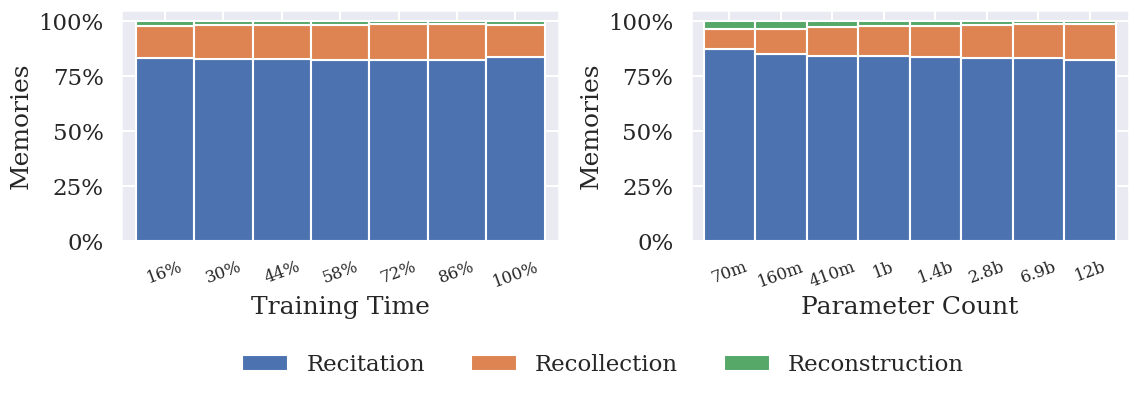

In [73]:
fig, axes = plt.subplots(1, 2, figsize=(13, 3))
plots = [
    (percents_frame_time, axes[0]),
    (percents_frame_scale, axes[1])
]

for idx, (data, ax) in enumerate(plots):
    data.plot.bar(
        stacked=True,
        ax=ax,
        rot=0,
        width=1,
        ylabel="Memories",
    )

    if idx == 0:
        ax.set_xlabel("Training Time")
    else:
        ax.set_xlabel("Parameter Count")
    
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}%".format(int(x * 100))))
    ax.tick_params(axis='x', rotation=20, labelsize=12)
    ax.get_legend().remove()

# Adjusting subplot parameters
fig.subplots_adjust(wspace=0.30)

# Common legend configuration
axes[0].legend(loc='upper center', bbox_to_anchor=(1.1, -0.4), ncol=4, frameon=False)

# align x axis labels
fig.align_xlabels()

# Save the figure
fig.savefig(f"{figures_path}/categories_percents_across_time+scale.pdf", bbox_inches="tight")


## Figure: Combined Counts + Percents Plot

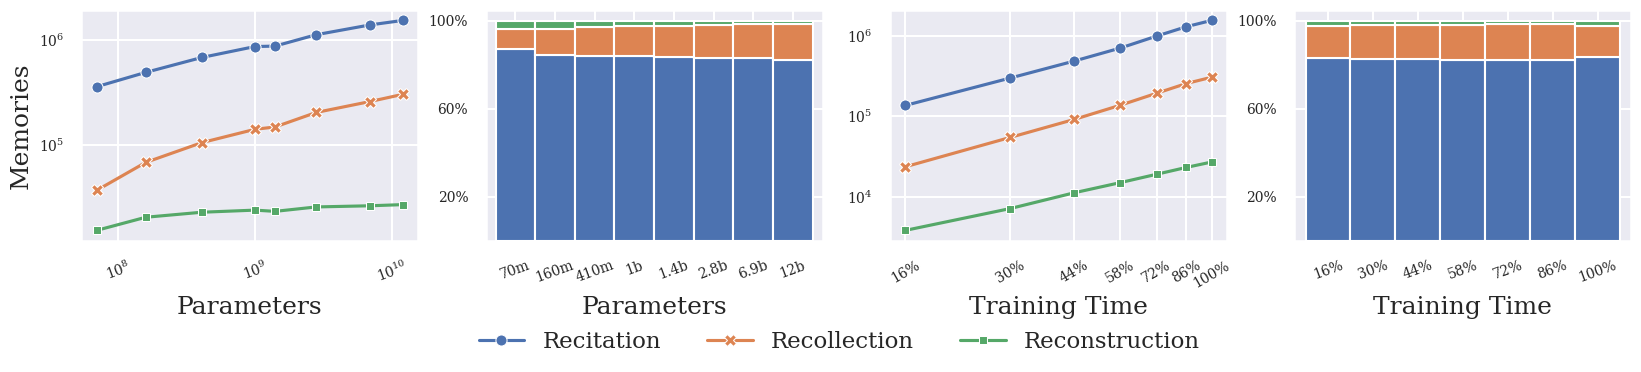

In [74]:
# Single row with four plots. Plot ordering is counts across scale, percents across scale, counts across time, percents across time
fig, axes = plt.subplots(1, 4, figsize=(20, 3))

# set figure 1
sns.lineplot(ax=axes[0], data=counts_frame_scale, dashes=False, markers=True, markersize=8)
axes[0].tick_params(axis='x', rotation=20, labelsize=10)
axes[0].set_yscale("log")
axes[0].set_xscale("log")
axes[0].tick_params(axis='y', labelsize=10)
axes[0].set_ylabel("Memories")
axes[0].set_xlabel("Parameters")
axes[0].legend(loc='upper center', bbox_to_anchor=(2.25, -0.3), ncol=4, frameon=False)

# set figure 2
percents_frame_scale.plot.bar(
    stacked=True,
    ax=axes[1],
    rot=0,
    width=1,
)
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}%".format(int(x * 100))))
axes[1].tick_params(axis='x', rotation=20, labelsize=10)
axes[1].tick_params(axis='y', labelsize=10)
axes[1].set_yticks([0.2, 0.6, 1])
axes[1].set_xlabel("Parameters")
axes[1].get_legend().remove()

# set figure 3
sns.lineplot(ax=axes[2], data=counts_frame_time, dashes=False, markers=True, markersize=8)
axes[2].set_yscale("log")
axes[2].tick_params(axis='x', labelsize=10)
axes[2].tick_params(axis='y', labelsize=10)
#  log x
axes[2].set_xscale("log", base=2)
# set x ticks at 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9
axes[2].set_xticks(sorted_checkpoints)
# axes[2].set_xticks([0.16, 0.2, 0.4, 0.8, 1])
# rotate
axes[2].tick_params(axis='x', rotation=30)
axes[2].set_xlabel("Training Time")
axes[2].xaxis.set_major_formatter(PercentFormatter(1))
axes[2].legend().remove()

# set figure 4
percents_frame_time.plot.bar(
    stacked=True,
    ax=axes[3],
    rot=0,
    width=1,
)
axes[3].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}%".format(int(x * 100))))
axes[3].tick_params(axis='x', rotation=20, labelsize=10)
axes[3].tick_params(axis='y', labelsize=10)
axes[3].set_yticks([0.2, 0.6, 1])
axes[3].set_xlabel("Training Time")
axes[3].get_legend().remove()

# make all the x labels have the same height
fig.align_xlabels()

# Save the figure
fig.savefig(f"{figures_path}/categories_counts_percents_across_time+scale.pdf", bbox_inches="tight")

### Same chart but with hugher bar charts

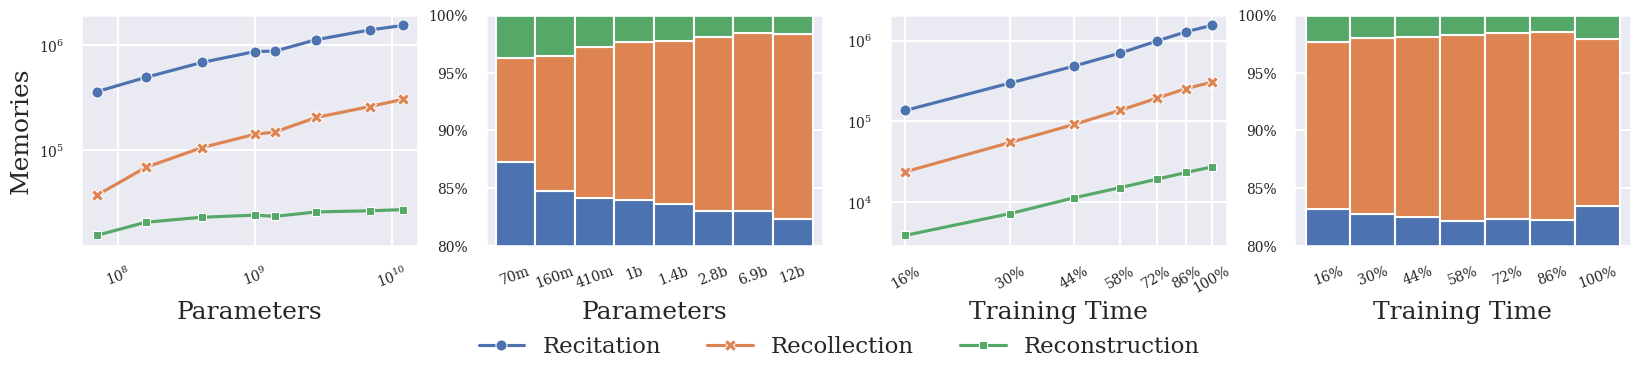

In [75]:
# Single row with four plots. Plot ordering is counts across scale, percents across scale, counts across time, percents across time
fig, axes = plt.subplots(1, 4, figsize=(20, 3))

# set figure 1
sns.lineplot(ax=axes[0], data=counts_frame_scale, dashes=False, markers=True, markersize=8)
axes[0].tick_params(axis='x', rotation=20, labelsize=10)
axes[0].set_yscale("log")
axes[0].set_xscale("log")
axes[0].tick_params(axis='y', labelsize=10)
axes[0].set_ylabel("Memories")
axes[0].set_xlabel("Parameters")
axes[0].legend(loc='upper center', bbox_to_anchor=(2.25, -0.3), ncol=4, frameon=False)

# set figure 2
percents_frame_scale.plot.bar(
    stacked=True,
    ax=axes[1],
    rot=0,
    width=1,
)
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}%".format(int(x * 100))))
axes[1].set_ylim(0.8, 1)
axes[1].set_yticks([0.8, 0.85, 0.9, 0.95, 1])
axes[1].tick_params(axis='x', rotation=20, labelsize=10)
axes[1].tick_params(axis='y', labelsize=10)
# axes[1].set_yticks([0.2, 0.6, 1])
axes[1].set_xlabel("Parameters")
axes[1].get_legend().remove()

# set figure 3
sns.lineplot(ax=axes[2], data=counts_frame_time, dashes=False, markers=True, markersize=8)
axes[2].set_yscale("log")
axes[2].tick_params(axis='x', labelsize=10)
axes[2].tick_params(axis='y', labelsize=10)
#  log x
axes[2].set_xscale("log", base=2)
# set x ticks at 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9
axes[2].set_xticks(sorted_checkpoints)
# axes[2].set_xticks([0.16, 0.2, 0.4, 0.8, 1])
# rotate
axes[2].tick_params(axis='x', rotation=30)
axes[2].set_xlabel("Training Time")
axes[2].xaxis.set_major_formatter(PercentFormatter(1))
axes[2].legend().remove()

# set figure 4
percents_frame_time.plot.bar(
    stacked=True,
    ax=axes[3],
    rot=0,
    width=1,
)
axes[3].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}%".format(int(x * 100))))
axes[3].set_ylim(0.8, 1)
axes[3].set_yticks([0.8, 0.85, 0.9, 0.95, 1])
axes[3].tick_params(axis='x', rotation=20, labelsize=10)
axes[3].tick_params(axis='y', labelsize=10)
axes[3].set_xlabel("Training Time")
axes[3].get_legend().remove()

# make all the x labels have the same height
fig.align_xlabels()

# Save the figure
fig.savefig(f"{figures_path}/categories_counts_percents_across_time+scale_bounded_bars.pdf", bbox_inches="tight")